In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

R² Score: 0.999
RMSE: 0.136
MAE: 0.058
Predictions saved to 'temp_forecast_lgbm_2024.csv'


/home/itsld/.local/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


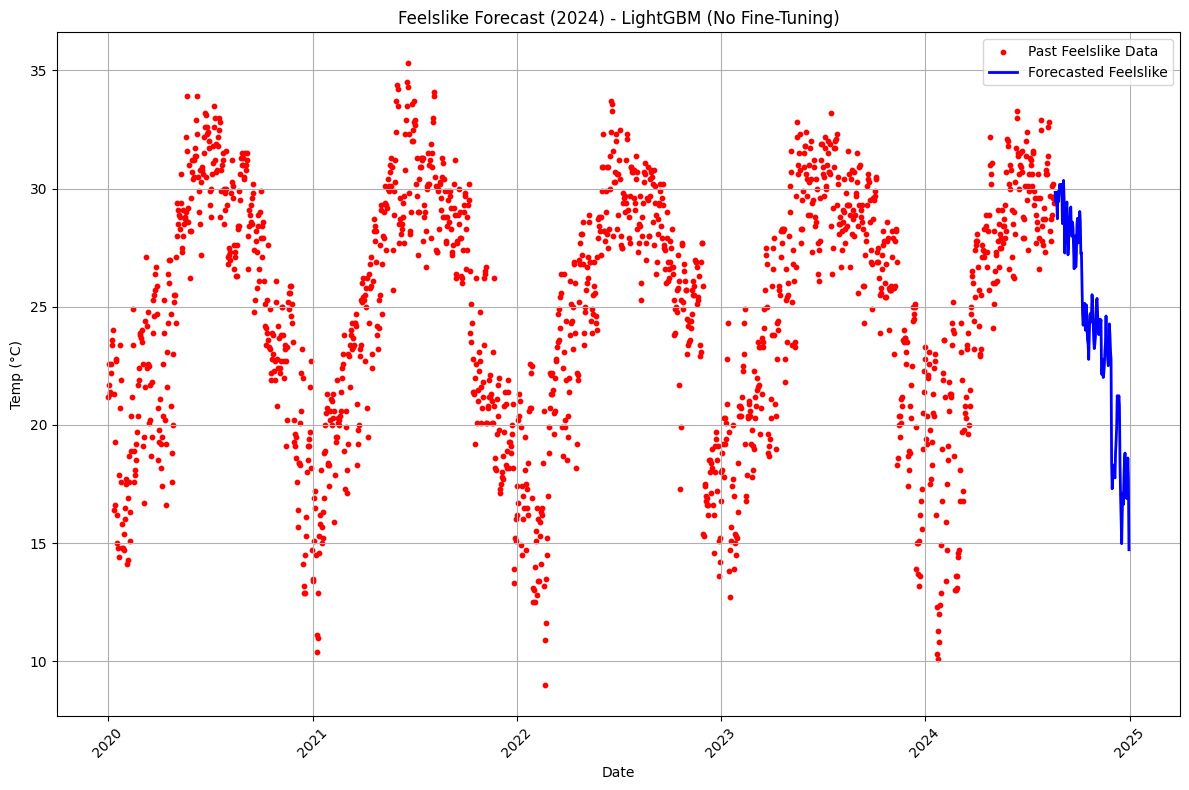

In [7]:
# Load the dataset
file_path = '/home/itsld/Documents/GitHub/AI_FOUND_TEAM_01/dataset/Data.csv' # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Prepare the data
data['datetime'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')
data['day_of_year'] = data['datetime'].dt.dayofyear

# Extract features and labels
X = data[['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity', 'day_of_year']]
y = data['temp']

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set LightGBM Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'early_stopping_round': 50  # Add this to the parameters
}

# Train the Model
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=1000)

# Make Predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Display the performance metrics
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Generate future dates (from 21/08/2024 to 31/12/2024)
future_dates = pd.date_range(start='2024-08-21', end='2024-12-31')
future_day_of_year = future_dates.dayofyear
future_data = pd.DataFrame({
    'day_of_year': future_day_of_year,
    'year': future_dates.year
})

# Use historical averages for each day of the year to simulate future features
historical_averages = data.groupby('day_of_year')[['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'sealevelpressure', 'humidity']].mean()
future_features = pd.DataFrame({
    'temp': [historical_averages.loc[day, 'temp'] for day in future_day_of_year],
    'tempmax': [historical_averages.loc[day, 'tempmax'] for day in future_day_of_year],
    'tempmin': [historical_averages.loc[day, 'tempmin'] for day in future_day_of_year],
    'feelslikemax': [historical_averages.loc[day, 'feelslikemax'] for day in future_day_of_year],
    'feelslikemin': [historical_averages.loc[day, 'feelslikemin'] for day in future_day_of_year],
    'feelslike': [historical_averages.loc[day, 'feelslike'] for day in future_day_of_year],
    'sealevelpressure': [historical_averages.loc[day, 'sealevelpressure'] for day in future_day_of_year],
    'humidity': [historical_averages.loc[day, 'humidity'] for day in future_day_of_year],
    'day_of_year': future_day_of_year
})

# Predict future feelslike
future_forecast = model.predict(future_features)
future_data['temp_forecast'] = future_forecast

# Display and save the predicted feelslike
future_data['ds'] = future_dates
future_data[['ds', 'temp_forecast']].to_csv('temp_forecast_lgbm_2024.csv', index=False)
print("Predictions saved to 'temp_forecast_lgbm_2024.csv'")

# Plot the forecasted feelslike and historical data
plt.figure(figsize=(12, 8))

# Plot historical data
plt.scatter(data['datetime'], data['temp'], color='red', label='Past Feelslike Data', s=10)

# Plot future predictions
plt.plot(future_data['ds'], future_data['temp_forecast'], color='blue', label='Forecasted Feelslike', linewidth=2)

# Add labels and title
plt.title("Feelslike Forecast (2024) - LightGBM (No Fine-Tuning)")
plt.xlabel("Date")
plt.ylabel("Temp (°C)")
plt.legend()

# Enhance the plot with grid and rotations
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
